In [27]:
import pandas as pd
import seaborn as sns

In [2]:
house_prices = pd.read_csv("/Users/admin/Desktop/UW/Academics/Fall_2022/DATA512/Project/data/raw/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
us_confirm_cases = pd.read_csv('../data/raw/confirmed_cases/RAW_us_confirmed_cases.csv')

## Data Processing

### House prices df

In [7]:
polk_df = house_prices.loc[(house_prices['RegionName'] == 'Polk County') & (house_prices['StateName'] == 'FL')]
polk_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000/1/31,...,2021/12/31,2022/1/31,2022/2/28,2022/3/31,2022/4/30,2022/5/31,2022/6/30,2022/7/31,2022/8/31,2022/9/30
97,285,97,Polk County,county,FL,FL,"Lakeland-Winter Haven, FL",12,105,101224.0,...,271475.0,277744.0,284030.0,291970.0,299863.0,307742.0,314304.0,319160.0,321991.0,322653


In [23]:
polk_house_prices = polk_df.iloc[:, 9:].T
polk_house_prices = polk_house_prices.reset_index()
polk_house_prices.rename(columns={97: 'house_avg_price', 'index': 'date'}, inplace=True)
polk_house_prices['date'] = pd.to_datetime(polk_house_prices['date'])

In [33]:
polk_house_prices

,date,house_avg_price
0,2000-01-31,101224.0
1,2000-02-29,101585.0
2,2000-03-31,101858.0
3,2000-04-30,102091.0
4,2000-05-31,102364.0
...,...,...
268,2022-05-31,307742.0
269,2022-06-30,314304.0
270,2022-07-31,319160.0
271,2022-08-31,321991.0


### Covid Case df

In [181]:
polk_confirm_cases = us_confirm_cases[(us_confirm_cases['Province_State'] == 'Florida') & (us_confirm_cases['Admin2'] == 'Polk')]
polk_confirm_cases = pd.DataFrame(polk_confirm_cases.iloc[:, 11:].iloc[0]).reset_index()
polk_confirm_cases.columns = ['Date', 'Confirmed_cases']
polk_confirm_cases['Date'] = pd.to_datetime(polk_confirm_cases['Date'])

In [182]:
polk_confirm_cases

,Date,Confirmed_cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
1010,2022-10-28,246656
1011,2022-10-29,246656
1012,2022-10-30,246656
1013,2022-10-31,246656


## Data Visualization

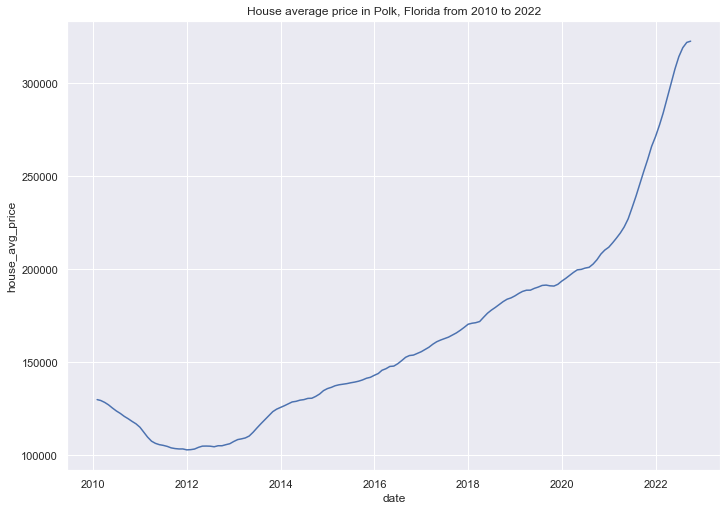

In [196]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.lineplot(x='date', y='house_avg_price', data=polk_house_prices.loc[polk_house_prices['date'] > '2010-01-01'])
g.set(title='House average price in Polk, Florida from 2010 to 2022')
plt.savefig('../img/house avg prices.png')

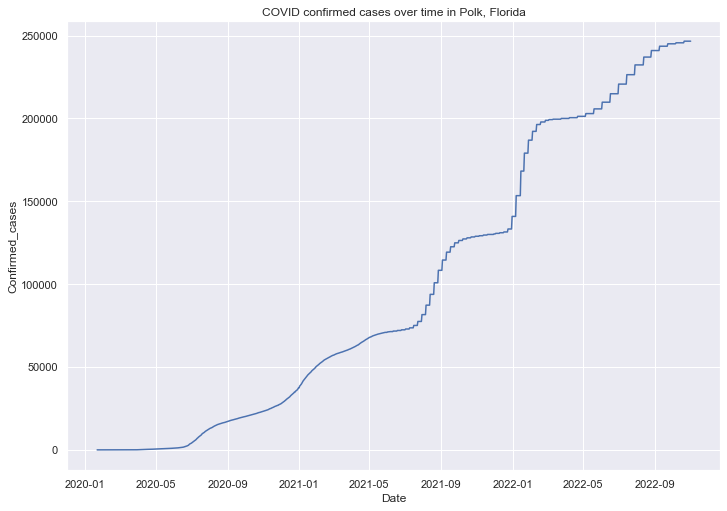

In [199]:
g = sns.lineplot(x='Date', y='Confirmed_cases', data=polk_confirm_cases)
g.set_title('COVID confirmed cases over time in Polk, Florida')
plt.savefig('../img/polk covid.png')

## Testing difference in slope of housing prices before and after the outbreak of COVID

In [168]:
polk_confirm_cases[-5:]
polk_house_prices[-5:]

,date,house_avg_price
268,2022-05-31,307742.0
269,2022-06-30,314304.0
270,2022-07-31,319160.0
271,2022-08-31,321991.0
272,2022-09-30,322653.0


The first case in Polk occurred on 2020-03-17, thus we would set that as the separation point for the time series. Since the house prices only contains data till 2022-09-30, we would be using the 927-day timeframe as the dataset after COVID, and the 927 days before 2020-03-17 as the dataset before COVID.
- Before COVID dataset: 2017-09-02 - 2020-03-16
- After COVID dataset: 2020-03-17 - 2022-09-30

In [112]:
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

before_covid = polk_house_prices.loc[(polk_house_prices['date'] >= '2017-09-02') & (polk_house_prices['date'] <= '2020-03-16')]
after_covid = polk_house_prices.loc[(polk_house_prices['date'] >= '2020-03-17') & (polk_house_prices['date'] <= '2022-09-30')]

### Before Covid

In [212]:
bef_model = LinearRegression()
before_covid['time_delta'] = before_covid['date'].apply(lambda x: (x - before_covid['date'].iloc[0]).days)
x, y = before_covid['time_delta'].values.reshape(-1, 1), before_covid['house_avg_price']
bef_model.fit(x, y)
bef_model.coef_, bef_model.intercept_, bef_model.score(x, y)

/var/folders/t1/t_yjgylx77s8pm8k27dxwr9m0000gn/T/ipykernel_7868/3960549694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_covid['time_delta'] = before_covid['date'].apply(lambda x: (x - before_covid['date'].iloc[0]).days)


(array([33.90778737]), 168003.4083262661, 0.9606523004272823)

In [213]:
# Using statsmodel
import statsmodels.api as sm
ols = sm.OLS(y, x)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        house_avg_price   R-squared (uncentered):                   0.779
Model:                            OLS   Adj. R-squared (uncentered):              0.771
Method:                 Least Squares   F-statistic:                              102.2
Date:                Mon, 05 Dec 2022   Prob (F-statistic):                    5.18e-11
Time:                        19:17:19   Log-Likelihood:                         -383.48
No. Observations:                  30   AIC:                                      769.0
Df Residuals:                      29   BIC:                                      770.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           314.7037     31.136     10.107      0.000     251.024     378.384
==============================================================================
Omnibus:                        5.312   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                1.805
Skew:                          -0.057   Prob(JB):                        0.406
Kurtosis:                       1.804   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression model has slope 33.91 and y-intercept 168003.41, with a R2 score of 0.96.

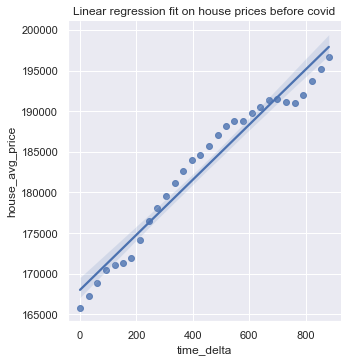

In [200]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(13.7,8.27)})
g = sns.lmplot(x = 'time_delta', y ='house_avg_price', data = before_covid).set(title='Linear regression fit on house prices before covid')
g.savefig("../img/lr_bef.png")

### After Covid

In [130]:
aft_model = LinearRegression()
after_covid['time_delta'] = after_covid['date'].apply(lambda x: (x - after_covid['date'].iloc[0]).days)
x, y = after_covid['time_delta'].values.reshape(-1, 1), after_covid['house_avg_price']
aft_model.fit(x, y)
aft_model.coef_, aft_model.intercept_, aft_model.score(x, y)

/var/folders/t1/t_yjgylx77s8pm8k27dxwr9m0000gn/T/ipykernel_7868/2639722265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_covid['time_delta'] = after_covid['date'].apply(lambda x: (x - after_covid['date'].iloc[0]).days)


(array([151.56395199]), 177446.24824629177, 0.9437592173308524)

In [209]:
# Using statsmodel
import statsmodels.api as sm
ols = sm.OLS(y, x)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        house_avg_price   R-squared (uncentered):                   0.867
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              195.0
Date:                Mon, 05 Dec 2022   Prob (F-statistic):                    1.15e-14
Time:                        19:15:17   Log-Likelihood:                         -398.09
No. Observations:                  31   AIC:                                      798.2
Df Residuals:                      30   BIC:                                      799.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           438.3387     31.388     13.965      0.000     374.236     502.441
==============================================================================
Omnibus:                        3.686   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                1.943
Skew:                           0.332   Prob(JB):                        0.379
Kurtosis:                       1.969   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression model results a slope of 151.56, a y-intercept of 177446.25 and a R2 score of 0.94.

In [206]:
model.score()

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

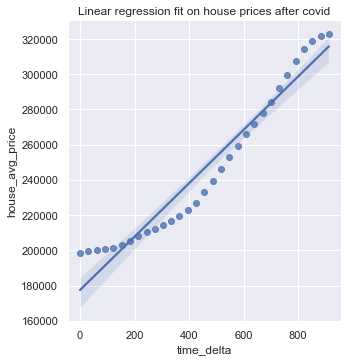

In [201]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(13.7,8.27)})
g = sns.lmplot(x = 'time_delta', y ='house_avg_price', data = after_covid).set(title='Linear regression fit on house prices after covid')
g.savefig('../img/lm_aft.png')

## Interpolation and Correlation

Interpolating each day's house prices for after covid. 

In [157]:
min_day, max_day = after_covid['time_delta'].iloc[0], after_covid['time_delta'].iloc[-1]

In [160]:
from scipy.interpolate import interp1d

days = np.linspace(min_day, max_day, max_day + 1).reshape(-1, 1)
interp_model = interp1d(after_covid['time_delta'], after_covid['house_avg_price'])
predicted_house_prices = interp_model(days)
days.shape, predicted_house_prices.shape

((914, 1), (914, 1))

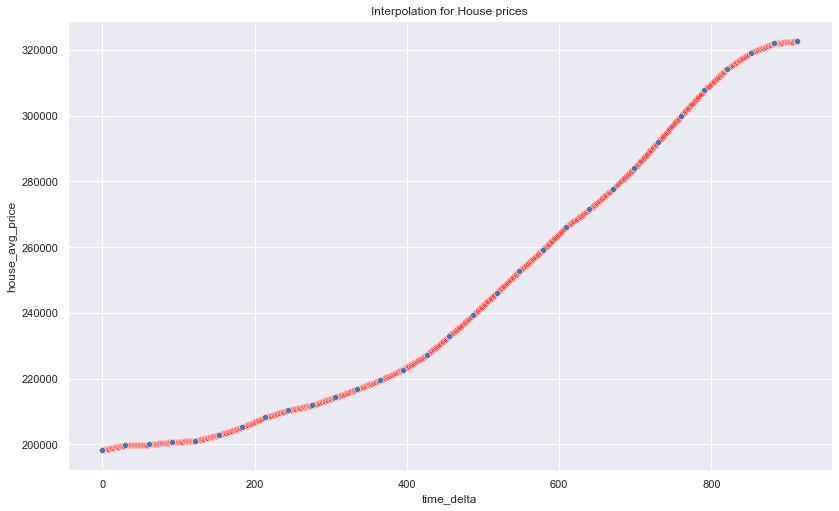

In [216]:
sns.scatterplot(x=days.reshape(-1), y=predicted_house_prices.reshape(-1), color='red')
sns.scatterplot(x=after_covid['time_delta'], y=after_covid['house_avg_price']).set_title('Interpolation for House prices')
plt.savefig('../img/interpolation.png')

### Generating correlation and cross-correlation plots

In [186]:
import scipy.stats

after_covid_polk_confirm_cases = polk_confirm_cases.loc[(polk_confirm_cases['Date'] <= '2022-09-30') & (polk_confirm_cases['Date'] >= '2020-03-31')]
correlation = scipy.stats.pearsonr(predicted_house_prices.reshape(-1), after_covid_polk_confirm_cases['Confirmed_cases'])
correlation

(0.991464123506658, 0.0)

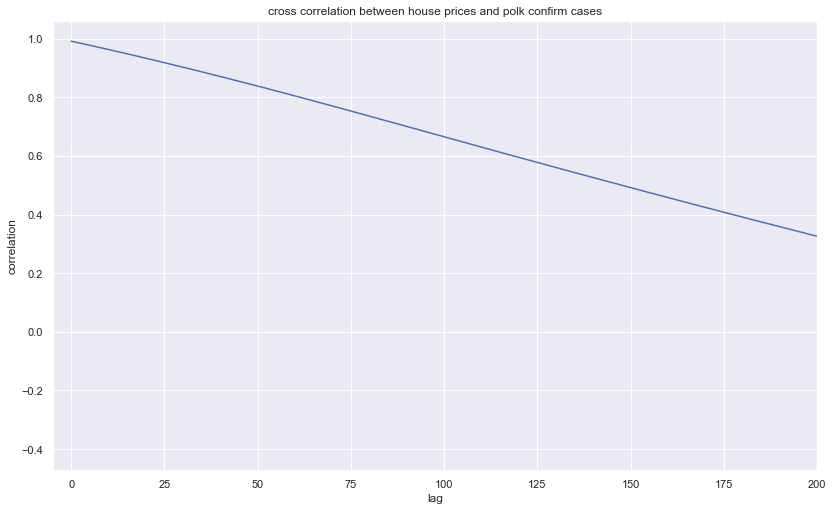

In [218]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

cross_corr = sm.tsa.ccf(after_covid_polk_confirm_cases['Confirmed_cases'], predicted_house_prices, adjusted=False)
plt.plot(cross_corr)
plt.xlim(-5, 200)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.title('cross correlation between house prices and polk confirm cases')
plt.savefig('../img/correlation.png')